# Synthetic data packages for Python

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

titanic_df = pd.read_csv('./data/titanic.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# DataSynthesizer

================ Constructing Bayesian Network (BN) ================
Adding ROOT Ticket
Adding attribute Pclass
Adding attribute Age
Adding attribute Survived
Adding attribute SibSp
Adding attribute Fare
Adding attribute Cabin
Adding attribute Parch
Adding attribute Embarked
Adding attribute Sex
========================== BN constructed ==========================
Constructed Bayesian network:
    Pclass   has parents ['Ticket'].
    Age      has parents ['Pclass', 'Ticket'].
    Survived has parents ['Pclass', 'Ticket'].
    SibSp    has parents ['Age', 'Pclass'].
    Fare     has parents ['Survived', 'Age'].
    Cabin    has parents ['Fare', 'Age'].
    Parch    has parents ['Cabin', 'Fare'].
    Embarked has parents ['Pclass', 'Ticket'].
    Sex      has parents ['Embarked', 'Parch'].


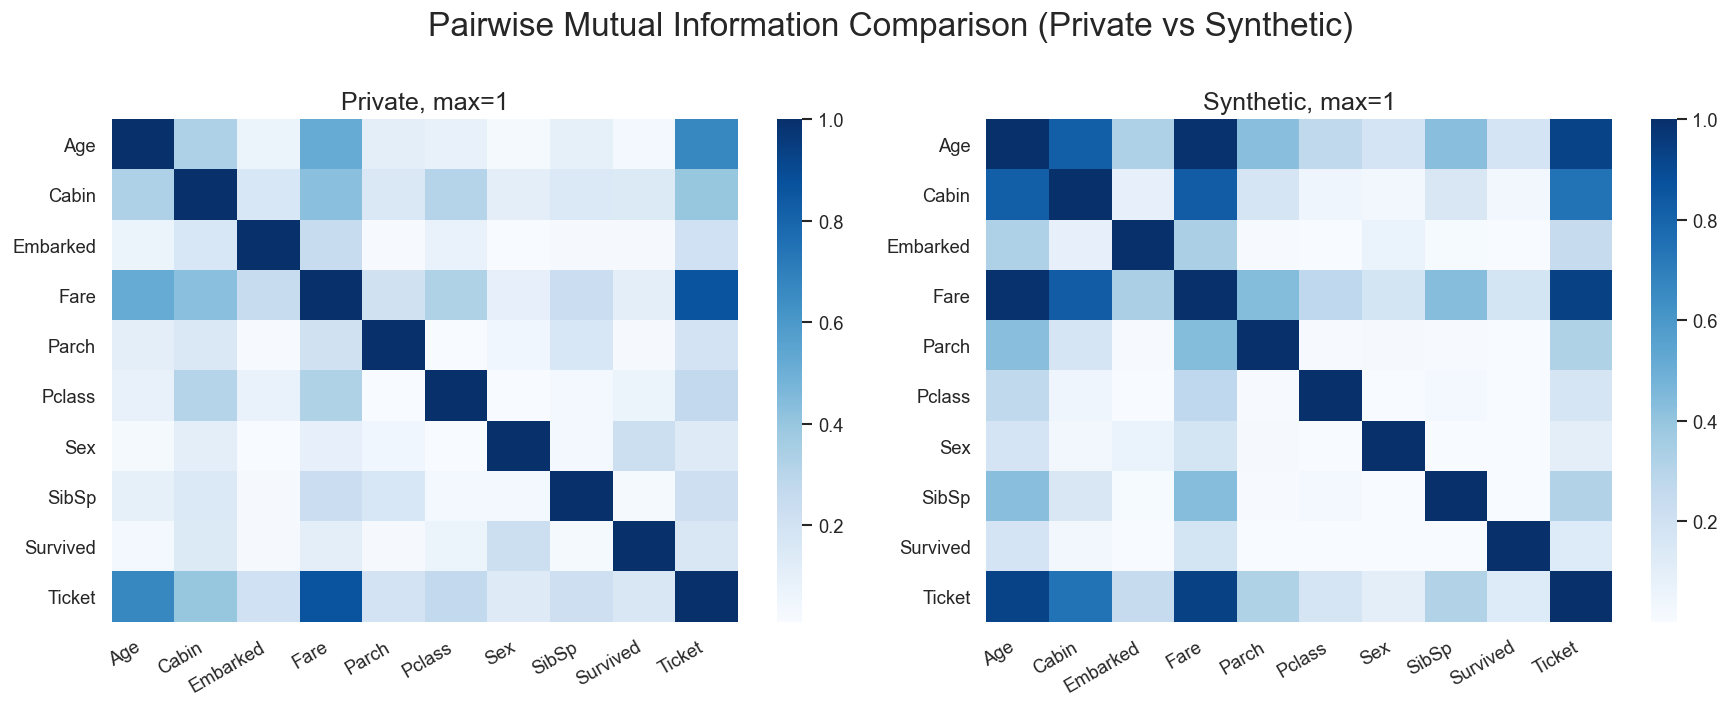

In [2]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

# input dataset
input_data = './data/titanic.csv'
# location of two output files
mode = 'correlated_attribute_mode'
description_file = f'./out/description.json'
synthetic_data = f'./out/sythetic_data.csv'

categorical_attributes = {'Name': True, 'Sex':True, 'Ticket':True, 'Cabin': True, 'Embarked': True}
candidate_keys = {'PassengerId': True}

# An attribute is categorical if its domain size is less than this threshold.
threshold_value = 20
# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 1
# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 2
# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = 1000

describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon, 
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)
display_bayesian_network(describer.bayesian_network)
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)
# Read both datasets using Pandas.

synthetic_df = pd.read_csv(synthetic_data)
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']
inspector = ModelInspector(titanic_df, synthetic_df, attribute_description)
inspector.mutual_information_heatmap()

# Pydbgen

In [3]:
import pydbgen
from pydbgen import pydbgen

src_db = pydbgen.pydb()
pydb_df = src_db.gen_dataframe(1000, fields=['name','city','phone','license_plate','ssn'], phone_simple=True)
pydb_df.head()

,name,city,phone-number,license-plate,ssn
0,Monica King,North East Carry,427-466-0831,TLD-171,138-97-2467
1,William Franklin,Fletcher,555-778-7683,8RWV879,782-65-9677
2,Madison Rodriguez,Sargeant,437-945-9821,YNE-638,839-53-5406
3,Juan Dixon,Saint Marks,190-228-9100,1WHI768,402-90-6966
4,Michael Lang,Symco,689-944-8685,VAW-372,516-65-3189


# Mimesis

In [4]:
from mimesis.schema import Field, Schema
from mimesis import Internet, Science

_ = Field()
description = (
    lambda: {
        'name': _('text.word'),
        'timestamp': _('timestamp', posix=False),
        'request': {
            'content_type': _('content_type'),
            'emoji': _('emoji'),
            'http_status_code': _('http_status_code'),
            'param1': _('dna_sequence'),
            'param2': _('rna_sequence')
        },
    }
)

schema = Schema(schema=description)
res_df = pd.DataFrame( schema.create(iterations=1000) )
req_df = pd.json_normalize( res_df['request'] ) 
pd.concat( [res_df, req_df], axis=1 ).drop('request', axis=1).head()

,name,timestamp,content_type,emoji,http_status_code,param1,param2
0,console,2019-09-11T23:22:09Z,Content-Type: message/rfc822,:rotating_light:,426,CATCTTTCGC,GCGCCCAGUG
1,fresh,2020-09-22T18:14:26Z,Content-Type: text/tab-separated-values,:station:,424,ATTAAATCAT,AGGGCUUCCA
2,pan,2021-03-23T11:17:51Z,Content-Type: video/vnd.radgamettools.smacker,:phone:,505,TTAGCTCTAA,AAUCGUGUUA
3,aol,2014-01-09T04:30:14Z,Content-Type: video/vnd.sealedmedia.softseal.mov,:man_with_turban:,304,CAGGGTCACC,AAAAUACAUG
4,refund,2005-09-09T14:51:46Z,Content-Type: video/vnd.dece.pd,:running_shirt_with_sash:,410,TATGCGCGTC,CUAACGCUUU


# SDV

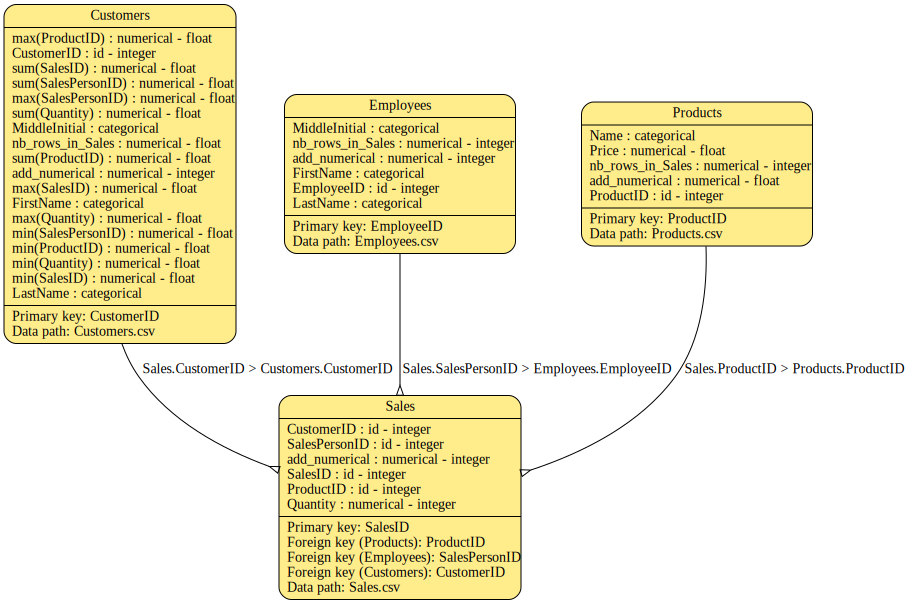

In [5]:
from sdv import load_demo

metadata, tables = load_demo('SalesDB_v1',metadata=True)
metadata.visualize()

In [6]:
tables['Customers'].head()

,CustomerID,FirstName,MiddleInitial,LastName,add_numerical,sum(SalesID),sum(SalesPersonID),sum(ProductID),sum(Quantity),max(SalesID),max(SalesPersonID),max(ProductID),max(Quantity),min(SalesID),min(SalesPersonID),min(ProductID),min(Quantity),nb_rows_in_Sales
0,1,Aaron,NaN,Alexander,1,1.266622e+09,5721.0,5721.0,63297.0,422146.0,1.0,1.0,195.0,9.0,1.0,1.0,10.0,5721.0
1,2,Aaron,NaN,Bryant,2,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Aaron,NaN,Butler,3,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Aaron,NaN,Chen,4,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Aaron,NaN,Coleman,5,2.449513e+09,1748.0,211071.0,431756.0,6053659.0,4.0,483.0,988.0,5147155.0,4.0,483.0,988.0,437.0


In [7]:
from sdv.relational import HMA1

model = HMA1(metadata)
model.fit( tables )
samples = model.sample(num_rows = 100 )
samples['Sales'].head()

,CustomerID,SalesPersonID,add_numerical,SalesID,ProductID,Quantity
0,2,90,1026637,0,66,412
1,2,99,1380419,1,41,563
2,2,71,2811127,2,41,612
3,2,2,1083329,3,95,558
4,2,22,1264616,4,95,522


# Plaitpy

/home/nickman/.virtualenvs/synthetic/lib/python3.8/site-packages/plaitpy/template.py:286: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  doc = yaml.load(data)


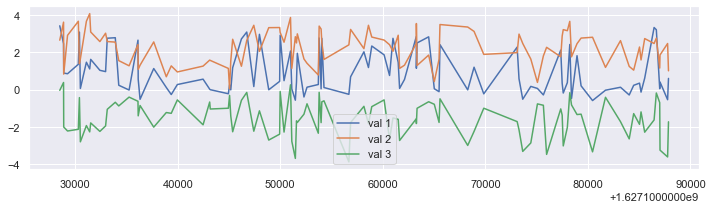

In [8]:
import plaitpy

fig, ax = plt.subplots(figsize=(12,3))
t = plaitpy.Template("./data/stocks.yml")
data = t.gen_records(100)
timeseries_df = pd.concat([pd.DataFrame(d, index=[1]) for d in data]).reset_index().drop('index', axis=1).sort_values(by='timestamp')
timeseries_df
ax.plot( timeseries_df['timestamp'], timeseries_df['val1'], label='val 1')
ax.plot( timeseries_df['timestamp'], timeseries_df['val2'], label='val 2')
ax.plot( timeseries_df['timestamp'], timeseries_df['val3'], label='val 3')
ax.legend()
plt.show()

# Scikit

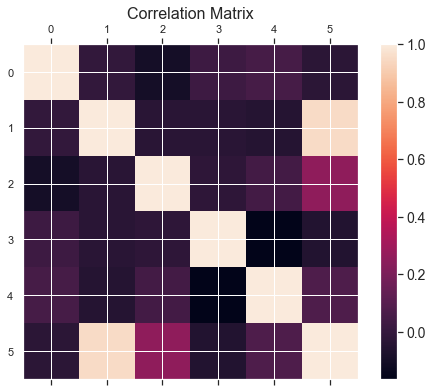

In [9]:
from sklearn import datasets
fig = plt.figure(figsize=(8, 6))
X, y = datasets.make_regression(n_samples=150, n_features=5,n_informative=3, noise=0.2)
reg_df = pd.DataFrame(X, columns=['Ft %i' % i for i in range(5)])
reg_df['y'] = y

plt.matshow( reg_df.corr(), fignum=fig.number )
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# Timeseries generator

<AxesSubplot:xlabel='date'>

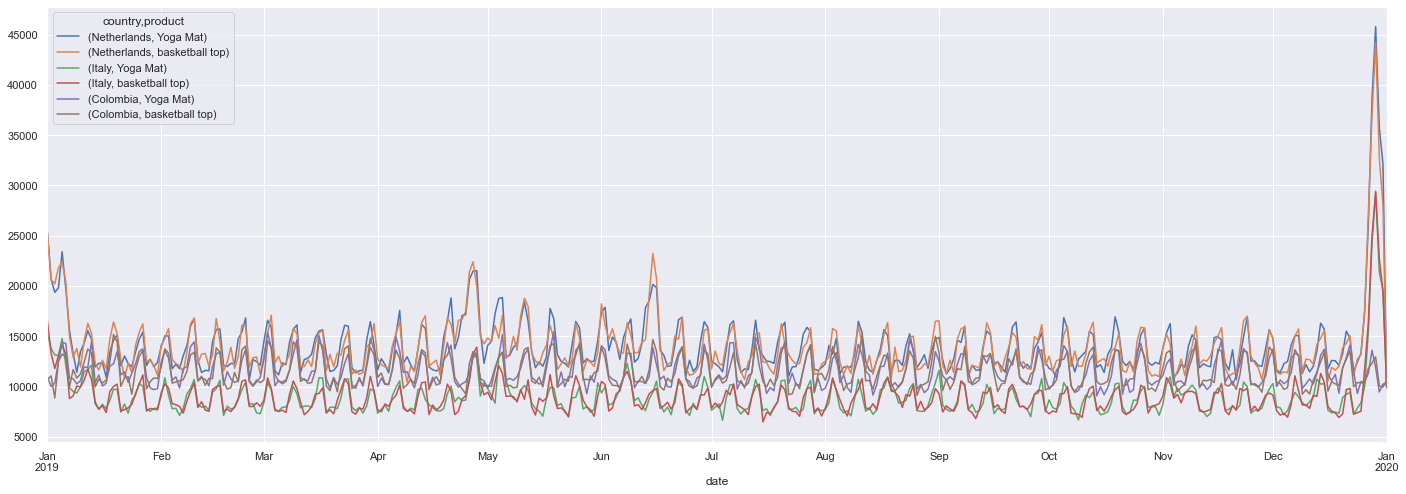

In [10]:
from pandas._libs.tslibs.timestamps import Timestamp
from timeseries_generator import LinearTrend, Generator, WhiteNoise, RandomFeatureFactor
from timeseries_generator.external_factors import CountryGdpFactor, EUIndustryProductFactor
from timeseries_generator import Generator, HolidayFactor, RandomFeatureFactor, WeekdayFactor, WhiteNoise

start_date = Timestamp("01-01-2019")
end_date = Timestamp("01-01-2020")
features_dict = {"country": ["Netherlands", "Italy", "Colombia"],
                "product": ["Yoga Mat", "basketball top"]}
g: Generator = Generator(
    factors={
        CountryGdpFactor(),
        EUIndustryProductFactor(),
        HolidayFactor(holiday_factor=2.,special_holiday_factors={"Christmas Day": 10.}),
        WeekdayFactor(col_name="weekend_boost_factor", factor_values={4: 1.15, 5: 1.3, 6: 1.3} ),
        WhiteNoise()
    },
    features=features_dict,
    date_range=pd.date_range(start=start_date, end=end_date),
    base_value=10000
)
    
df = g.generate()
    
plot_df = df.set_index('date')
plot_df[['country', 'value', 'product']].pivot(columns=['country', 'product'], values='value').plot(figsize=(24,8))